# CS4035 - Cyber Data Analytics
## Lab 2 

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

#### Importing Necessary Libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import collections
import math
import itertools
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
%config InlineBackend.figure_format = 'retina'

## Parsing the data.


In [78]:
#Please provide the correct path for these datasets below. 
data = pd.read_csv("BATADAL_dataset03.csv")
dataA = pd.read_csv("BATADAL_dataset04.csv")
# To remove the annoying ' ' before column names in the validation set
dataA.columns = ['DATETIME', 'L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6',
       'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3',
       'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7',
       'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10',
       'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300',
       'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307',
       'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG']
# Converting the labels of dataA to 1s and 0s
dataA['ATT_FLAG'] = dataA['ATT_FLAG'].apply(lambda x: 0 if x < 1 else 1)
#Converting DATETIME to a timestamp format and setting the index.
data["DATETIME"]= pd.to_datetime(data["DATETIME"])
data = data.set_index('DATETIME')
dataA["DATETIME"]= pd.to_datetime(dataA["DATETIME"])
dataA = dataA.set_index('DATETIME')
testdata=pd.read_csv("BATADAL_test_dataset.csv")
#Creating year, month, weekday_name and hour variables for each data point.
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Weekday Name'] = data.index.weekday_name
data['Hour'] = data.index.hour
test_df = pd.read_csv('BATADAL_test_dataset.csv')
y_test = test_df[['Labels']].values
test_df = test_df.drop(['Labels'], axis=1)

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

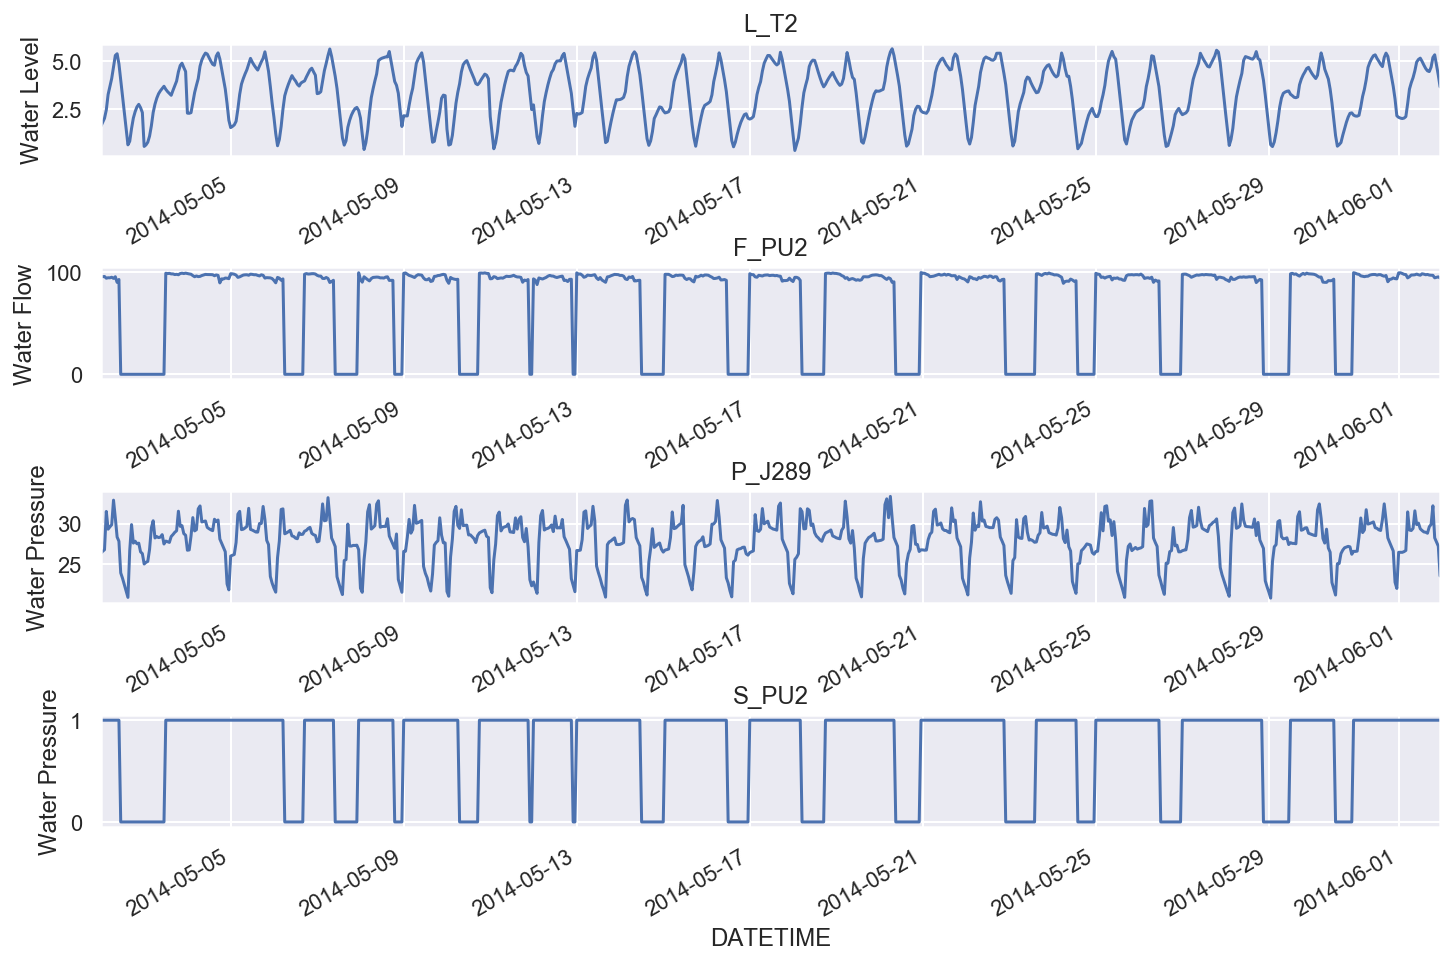

In [6]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize =(12, 8))
data.loc['2014-05-01':'2014-06-01', 'L_T2'].plot(linestyle='-', ax=ax1)
ax1.set_ylabel('Water Level')
ax1.set_title("L_T2")
ax1.set_xlabel('')
data.loc['2014-05-01':'2014-06-01', "F_PU2"].plot(linestyle='-',ax=ax2)
ax2.set_ylabel('Water Flow')
ax2.set_title("F_PU2")
ax2.set_xlabel('')
data.loc['2014-05-01':'2014-06-01', 'P_J289'].plot(linestyle='-',ax=ax3)
ax3.set_ylabel('Water Pressure')
ax3.set_title('P_J289')
ax3.set_xlabel('')
data.loc['2014-05-01':'2014-06-01', 'S_PU2'].plot(linestyle='-',ax=ax4)
ax4.set_ylabel('Water Pressure')
ax4.set_title('S_PU2')
plt.subplots_adjust(hspace=1)
plt.show()

In [63]:
dataA

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,F_PU2,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
DATETIME,,,,,,,,,,,,,,,,,,,,,
2016-04-07 00:00:00,2.44,5.24,3.19,4.10,2.86,5.50,4.39,93.63,1.0,93.65,...,70.00,28.22,85.87,21.69,82.72,21.58,71.99,39.33,29.64,-999
2016-04-07 01:00:00,2.66,4.53,3.20,4.18,3.29,5.44,4.53,89.41,1.0,89.43,...,87.73,24.45,84.87,29.81,86.62,29.81,59.76,42.17,26.15,-999
2016-04-07 02:00:00,3.11,3.66,3.66,4.21,3.87,5.15,3.22,89.88,1.0,89.89,...,89.29,23.90,87.11,29.85,87.64,29.85,58.50,42.00,25.56,-999
2016-04-07 03:00:00,3.62,3.04,4.17,4.04,3.56,4.98,2.40,88.10,1.0,88.12,...,91.98,27.10,68.75,31.60,64.25,31.47,72.30,43.24,28.38,-999
2016-04-07 04:00:00,4.08,2.68,4.73,3.20,3.11,5.39,3.46,87.01,1.0,87.03,...,92.11,26.76,68.74,32.30,64.23,32.17,72.53,44.00,28.04,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-24 20:00:00,2.65,2.37,3.85,3.04,3.82,4.94,2.19,120.08,1.0,0.00,...,70.03,27.38,84.14,18.45,81.67,18.34,66.04,29.88,28.98,-999
2016-12-24 21:00:00,2.24,2.56,3.42,2.92,3.69,5.02,1.97,119.12,1.0,0.00,...,68.60,27.66,83.46,25.40,60.85,25.28,66.89,30.19,29.29,-999
2016-12-24 22:00:00,1.91,2.76,2.95,2.49,2.70,5.14,1.87,120.71,1.0,0.00,...,85.63,26.84,82.82,24.46,59.56,24.34,66.08,29.68,28.78,-999


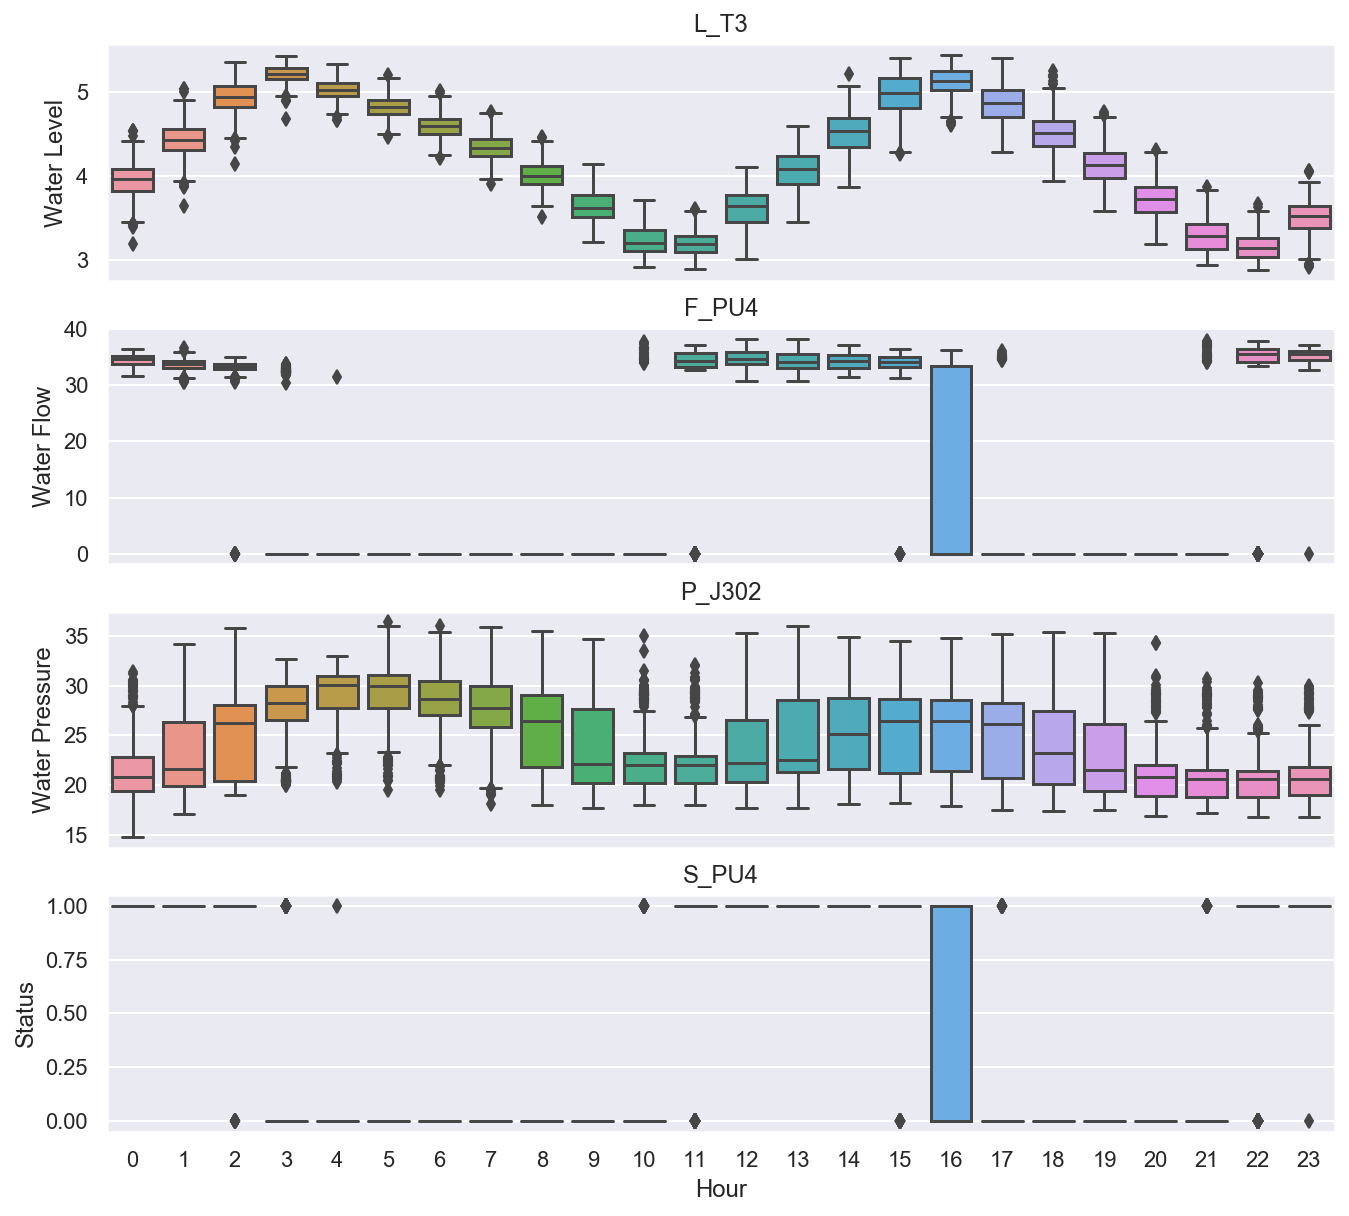

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=True)
for yaxis,name, ax in zip(["Water Level","Water Flow","Water Pressure","Status"],['L_T3', 'F_PU4', 'P_J302',"S_PU4"], axes):
    sns.boxplot(data=data, x='Hour', y=name, ax=ax)
    ax.set_ylabel(yaxis)
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

### 1b-I) What type of signals are there ?

#### We have FOUR main types of signals in the dataset, namely:
* **Water Levels** associated with the water tanks denoted by "L_Tank[ID]". (7 variables)
* **inlet and outlet pressure** associated with the actuated valves and pumping stations denoted as "P_Junction[ID]". (12 variables).
* **Flow** through the actuated valves and pumps denoted using "F_actuatorID" (12 Variables)
* Status of the actuated valves and pumps denoted by "S_actuatorID". (12 Variables)

### 1b-II) Are the signals correlated, do they show cyclic behaviour ?

1) Firstly, based on the above visualization, which shows the 4 different signals as discussed in the previous question, we see signs of _correlation_. More specifically, we see that the flow of water through pump 2 is positively correlated with the status. Moreover, we can also start to see similar temporal patterns for the water level at tank 2 and the pressure at junction 289. ( More generally, we find that the flow and status of actuated valves and pumps are always positively correlated. )

2) We can also spot cyclic behaviour for some of the signals. If we look at the box plots made for the different signals with respect to their hourly values, we can clearly see a cyclic pattern especially for water levels for tank 3 (L_T3).

In [23]:
# Significant correlation between water level at tank 2 and pressure at P_J289 as well between flow and status at pump 2. 
(np.corrcoef(data["L_T2"],data["P_J289"])[1][0],np.corrcoef(data["F_PU2"],data["S_PU2"])[1][0])

(0.5947713172315867, 0.9986139581288059)

### 1b-III) Is predicting the next value in a series easy or hard?

**Note** Here we use a sliding window approach to predict the next value of a series. The dataset is created by choosing a signal i.e L_T1 in our case and using a sliding window of 23 timesteps. Therefore 23 values preceeding the 24th value of the series is considered to be the features with the 24th value being the associated label for our dataset. We then train a random forest regressor model on the first training dataset and use a randomized grid search to find the best paramaters for the model based on the second training dataset. We finally generate predictions using the best parameters we found through the validation set and use those for the test set. We conclude with our findings. 

In [24]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 55, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [25]:
# Using a 24 hour sliding window approach to create train, val and test sets. 
LT1=data["L_T1"].values[1:]
TrainingData = pd.DataFrame(LT1.reshape(365,24))
X = TrainingData.iloc[:,:22]
Y = TrainingData.iloc[:,23]
ValidationData=dataA["L_T1"].values[1:]
ValidationData = pd.DataFrame(ValidationData.reshape(174,24))
X_val = ValidationData.iloc[:,:22]
Y_val = ValidationData.iloc[:,23]
test_LT1=testdata["L_T1"].values[1:]
testData = pd.DataFrame(test_LT1.reshape(87,24))
X_test = testData.iloc[:,:22]
Y_test = testData.iloc[:,23]

In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model 
y_pred = rf_random.fit(X, Y).predict(X_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.1s finished


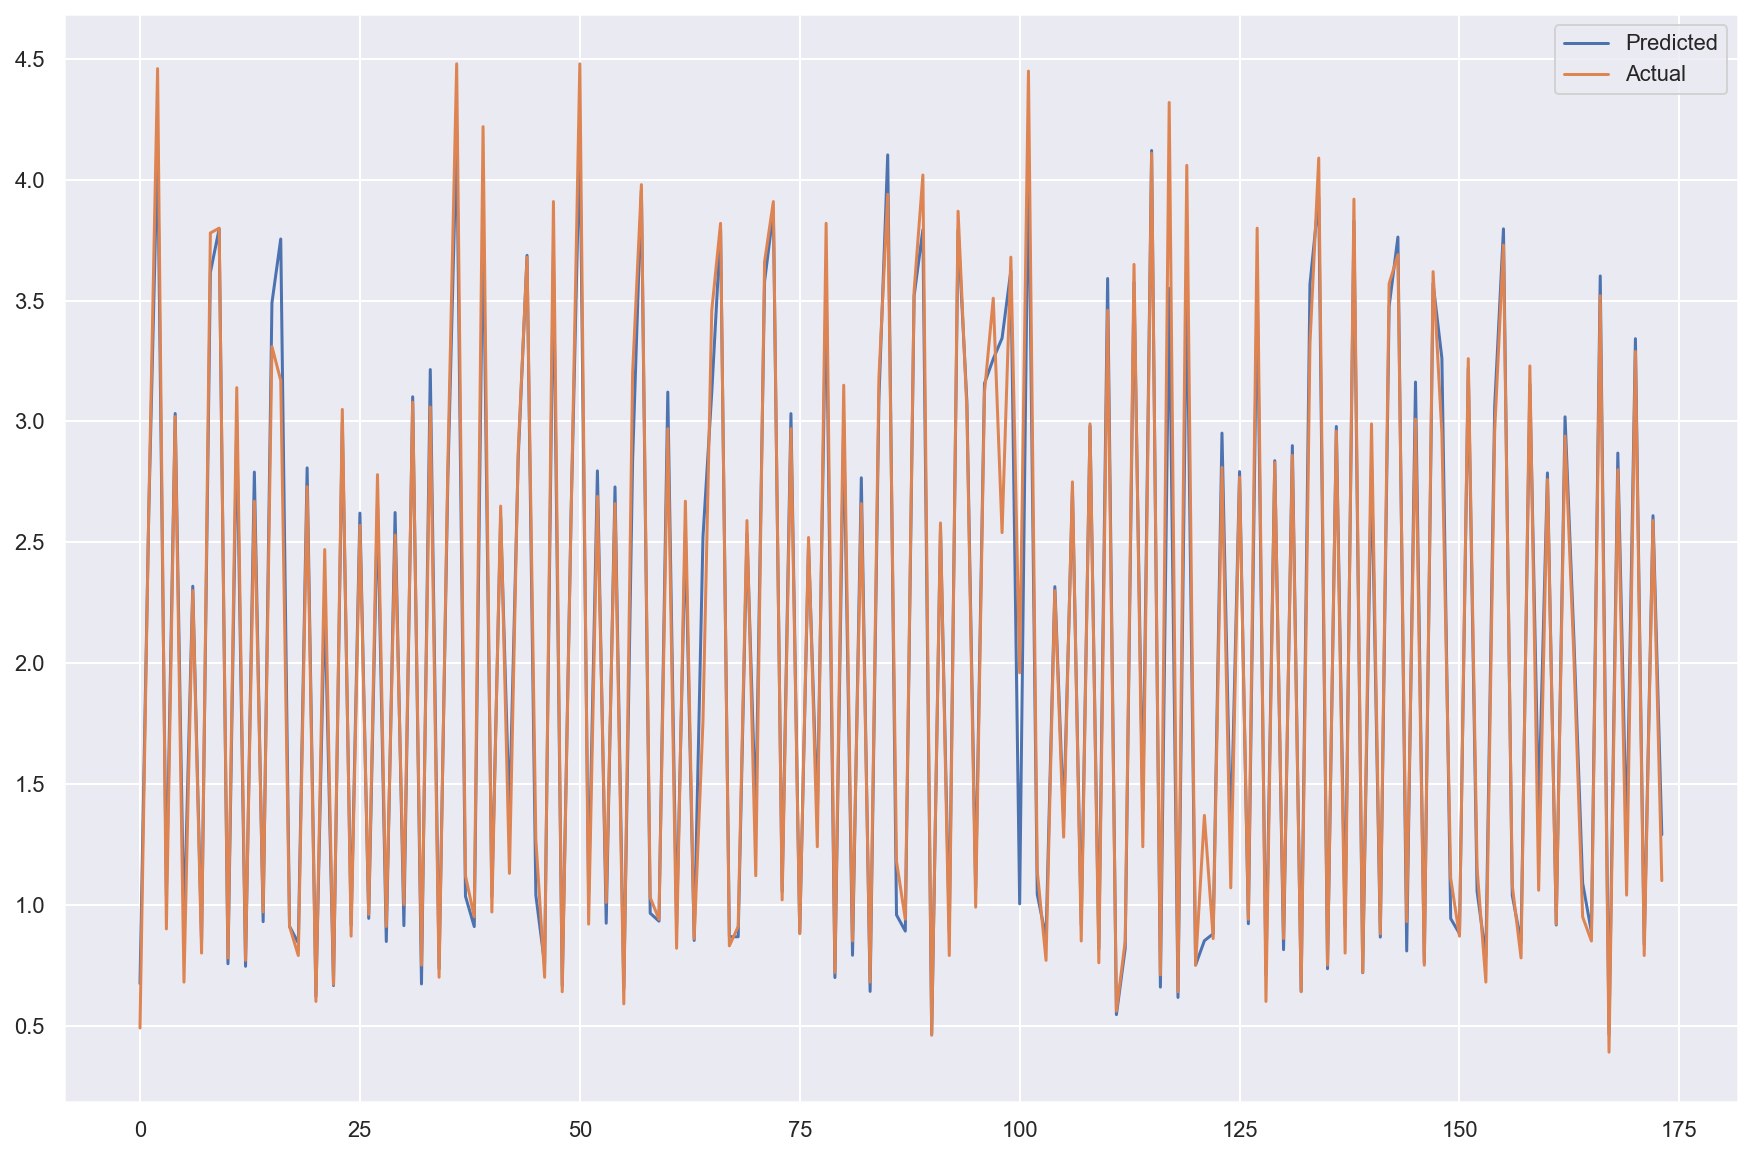

In [27]:
plt.plot(y_pred,label="Predicted")
plt.plot(Y_val,label="Actual")
plt.legend()
plt.show()

In [28]:
mean_squared_error(Y_val,y_pred)

0.035244938607130925

In [29]:
rf_random.best_params_

{'n_estimators': 30,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 42,
 'bootstrap': True}

In [30]:
rf = RandomForestRegressor(n_estimators=40,min_samples_split=2,min_samples_leaf=1,max_features="auto",max_depth=None,bootstrap=True)
y_pred_test = rf.fit(X, Y).predict(X_test)

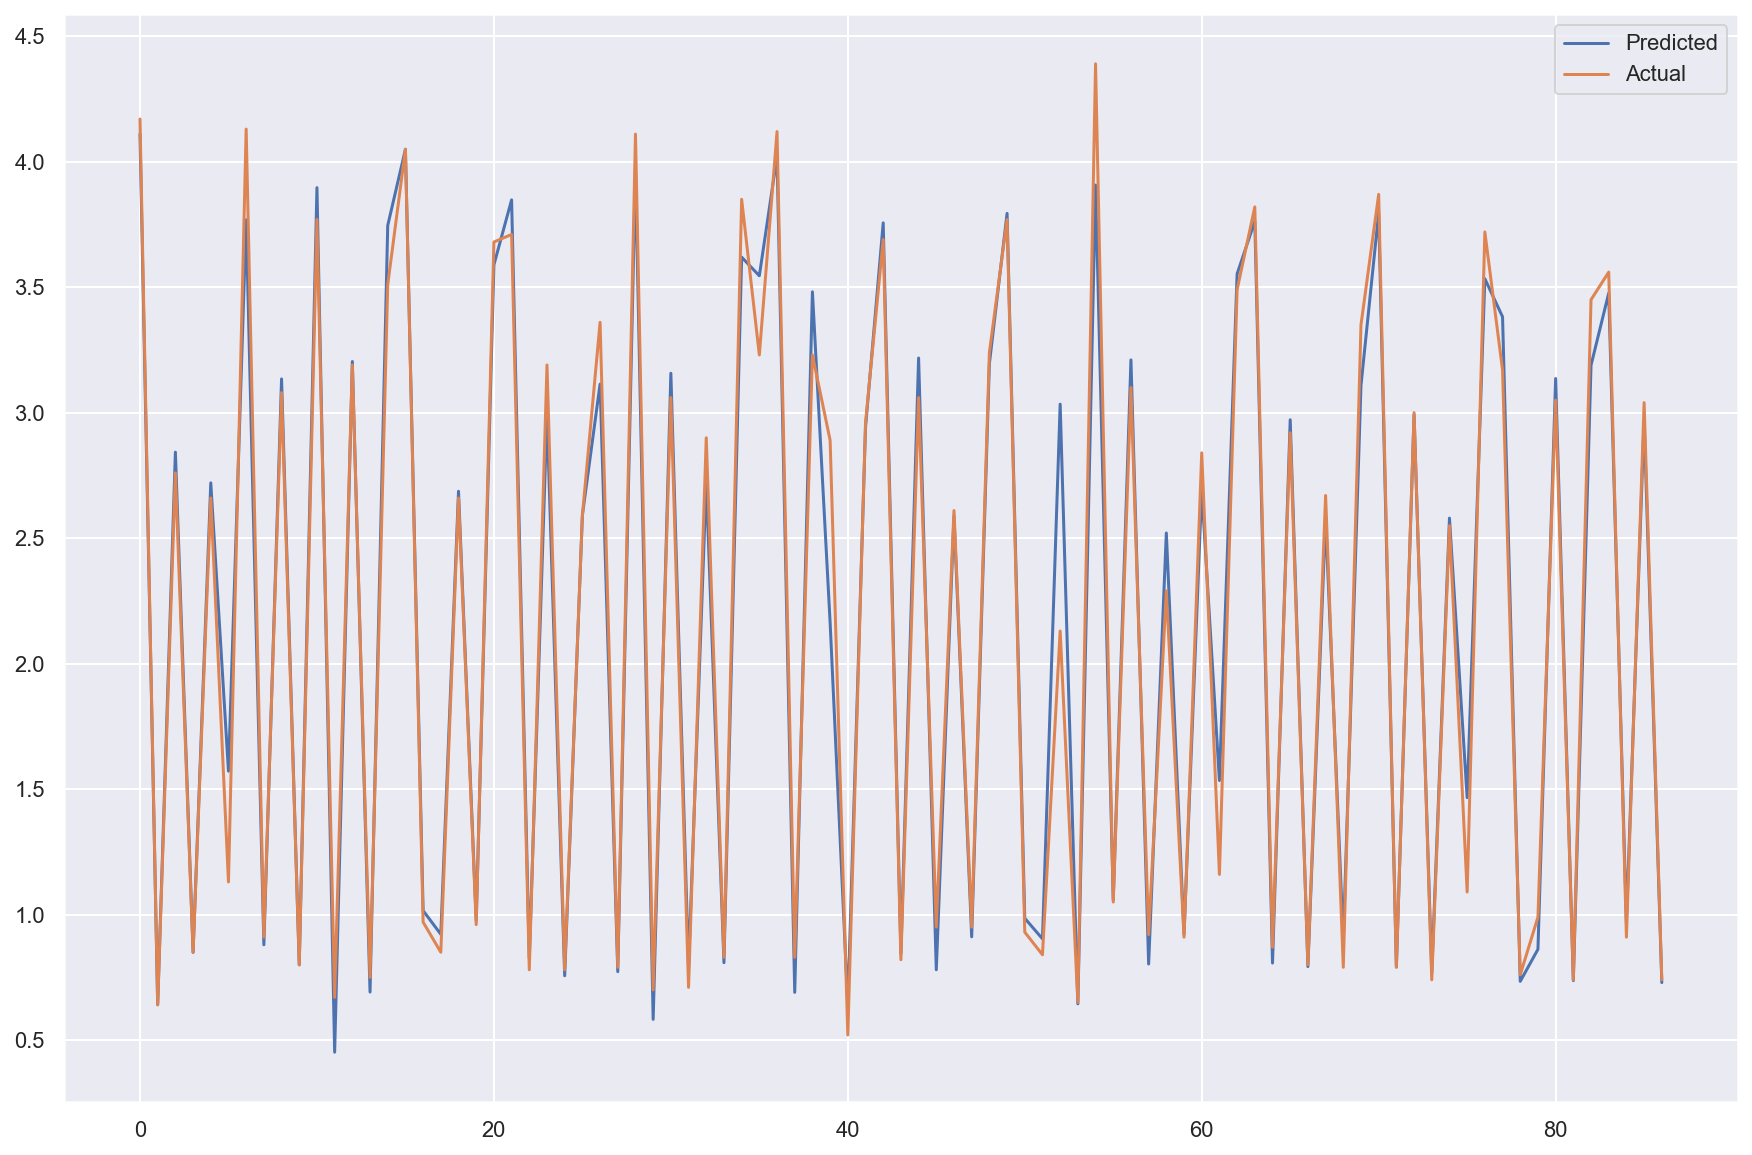

In [31]:
plt.plot(y_pred_test,label="Predicted")
plt.plot(Y_test,label="Actual")
plt.legend()
plt.show()

In [32]:
mean_squared_error(Y_test,y_pred_test)

0.03749982959239508

Therefore based on the plots and the mean squared error which was quite low as well, we can say predicting the next value in the water levels for tank 1 i.e L_T1 is relatively straightforward. 

## 2. LOF task – 1/2 A4 – Anwesh Marwade

### 2a. Plot LOF scores

In [39]:
# Helper Functions for LOF Task

# Function to calculate Euclidean distance given two points
def euclideanDistance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance = distance + (row1[i] - row2[i])**2
    return math.sqrt(distance)

# Function to calculate k-nearest neighbours as a list, given a point.
def k_neighbors(curr_row, data, k):
    i = 0
    dist_list = list()
    for idx in range(len(data)):
        dist = euclideanDistance(curr_row, data[idx])
        dist_list.append((idx, dist))
        
    dist_list.sort(key=lambda tup: tup[1])
    k_neighbours = list()
    
#   k+1 as the closest neighbour is the point itself
    for i in range(k+1):
        k_neighbours.append(dist_list[i][0])
        
    return k_neighbours[1:]

# Function to calculate the 'reach_distance'
def reach_dist(row1, row2, k_distance):
    return max(euclideanDistance(row1, row2), k_distance)

In [43]:
def LOF(data, k=2):
    k_distance = np.zeros(len(data))
    
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(data)
    distances, knn_list = nbrs.kneighbors(data)

    for i in range(len(data)):
        k_distance[i] = euclideanDistance(data[i], data[int(knn_list[i][k])])

    lrd = np.zeros(len(data))
    for i in range(len(data)):
        sum_reach_dist = 0
        nn_list = knn_list[i][1:]
        for j in range(len(nn_list)):
            sum_reach_dist = sum_reach_dist + reach_dist(data[i], data[int(nn_list[j])], k_distance[int(nn_list[j])])
        lrd[i] =  len(nn_list)/sum_reach_dist
    lof = np.zeros(len(data))

    for i in range(len(data)):
        nn_list = knn_list[i][1:]
        sum_lrd = 0
        sum_rd = 0
        for j in range(len(nn_list)):
            sum_lrd = sum_lrd + lrd[int(nn_list[j])]
            sum_rd = sum_rd + reach_dist(data[i], data[int(nn_list[j])], k_distance[int(nn_list[j])])
        lof[i] = (sum_lrd*sum_rd)/(len(nn_list)*len(nn_list))
    return lof

In [47]:
nn_array = [2, 10, 50, 100, 150, 200, 300]

lof_df = data.drop(['ATT_FLAG', 'Year',
       'Month', 'Weekday Name', 'Hour'], axis=1)
lof_df_validation = dataA.drop(['ATT_FLAG'], axis=1)

lof_mat = np.zeros((len(nn_array),len(data)))
lof_mat_validation = np.zeros((len(nn_array),len(dataA)))

for idx, z in enumerate(nn_array):
    lof_mat[idx] = LOF(lof_df.values, z)
    lof_mat_validation[idx] = LOF(lof_df_validation.values, z)

avg_lof = np.zeros(len(nn_array))
avg_lof_validation = np.zeros(len(nn_array))
for index in range(len(nn_array)):
    avg_lof[index] = np.mean(lof_mat[index])
    avg_lof_validation[index] = np.mean(lof_mat_validation[index])

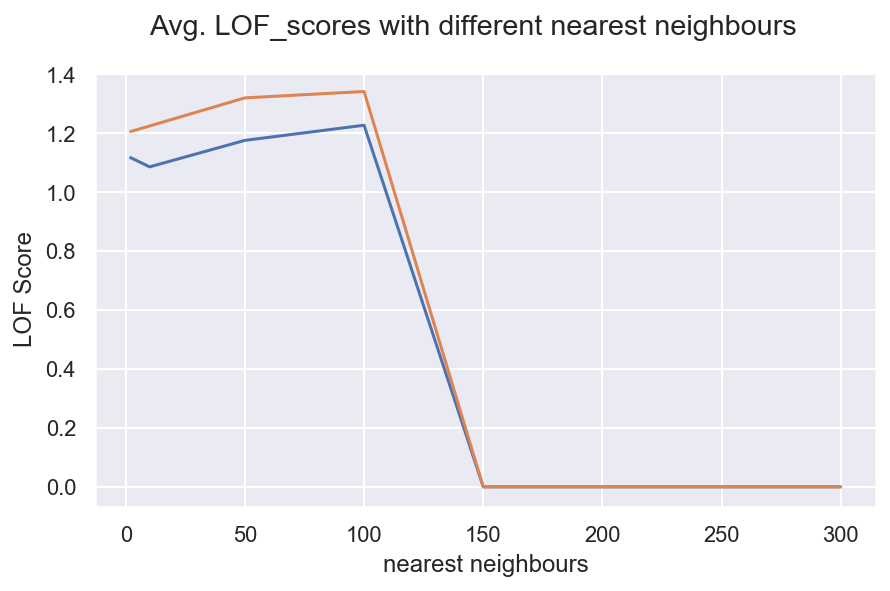

In [106]:
fig = plt.figure(figsize=(7,4))
fig.suptitle('Avg. LOF_scores with different nearest neighbours')
plt.xlabel('Nearest neighbours')
plt.ylabel('LOF Score')
plt.plot(nn_array, avg_lof)
plt.plot(nn_array, avg_lof_validation)

In [173]:
dflof = pd.DataFrame(lof_mat_validation[3])
lof_predictions = dflof[0].apply(lambda x: 1 if x > 2 else 0).values

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Anomaly')]

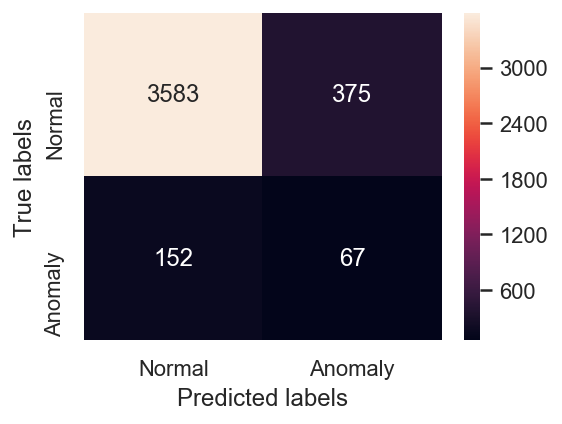

In [174]:
cm = confusion_matrix(dataA['ATT_FLAG'].values, lof_predictions)
akws = {"ha": 'center',"va": 'center'}
fig = plt.figure(figsize=(4,3))
fig = plt.plot(figsize=(7,3))
ax = sns.heatmap(cm, annot=True, fmt="d", annot_kws=akws)

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
# ax.set_title('Confusion Matrix-UnSmoted NB')
ax.xaxis.set_ticklabels(['Normal', 'Anomaly']); ax.yaxis.set_ticklabels(['Normal', 'Anomaly'])

### 2b. Analysis and answers to the questions

## 3. PCA task – 1/2 A4 – Individual

### 3a. Plot PCA residuals

### 3b. Analysis and answers to the questions

## 4. ARMA task – 1/2 A4 - Individual

### 4a. Print relevant plots and/or metrics to determine the parameters.

### 4b. Plots to study the detected anomalies

### 4c. Analysis and answers to the questions

## 5. N-gram task – 1/2 A4 - Anwesh Marwade

In [141]:
def assign_sym(x, quantiles):
    for i in range(len(quantiles)):
        if x < quantiles.values[i]:
            return i
    return i+1

def discretize(col, p = 9): 
    quantiles = []
    quantiles = col.quantile(np.linspace(.1, 1, p, 0))
    percentiles = col.apply(lambda x: assign_sym(x, quantiles))
    return percentiles.values

def get_freq(ngram, data, ngram_map):
    gram_list = []
    for i in range(len(data)):
        if(len(data) - i > ngram-1):
            gram = ','.join(str(n) for n in data[i:i+ngram])
            count = ngram_map.get(gram)
            if count is not None:
                ngram_map[gram] = count + 1
    return list(ngram_map.values())

# discrete_counts

### 5a. Visualise discretization

([<matplotlib.axis.YTick at 0x1a5163a890>,
 <a list of 10 Text yticklabel objects>)

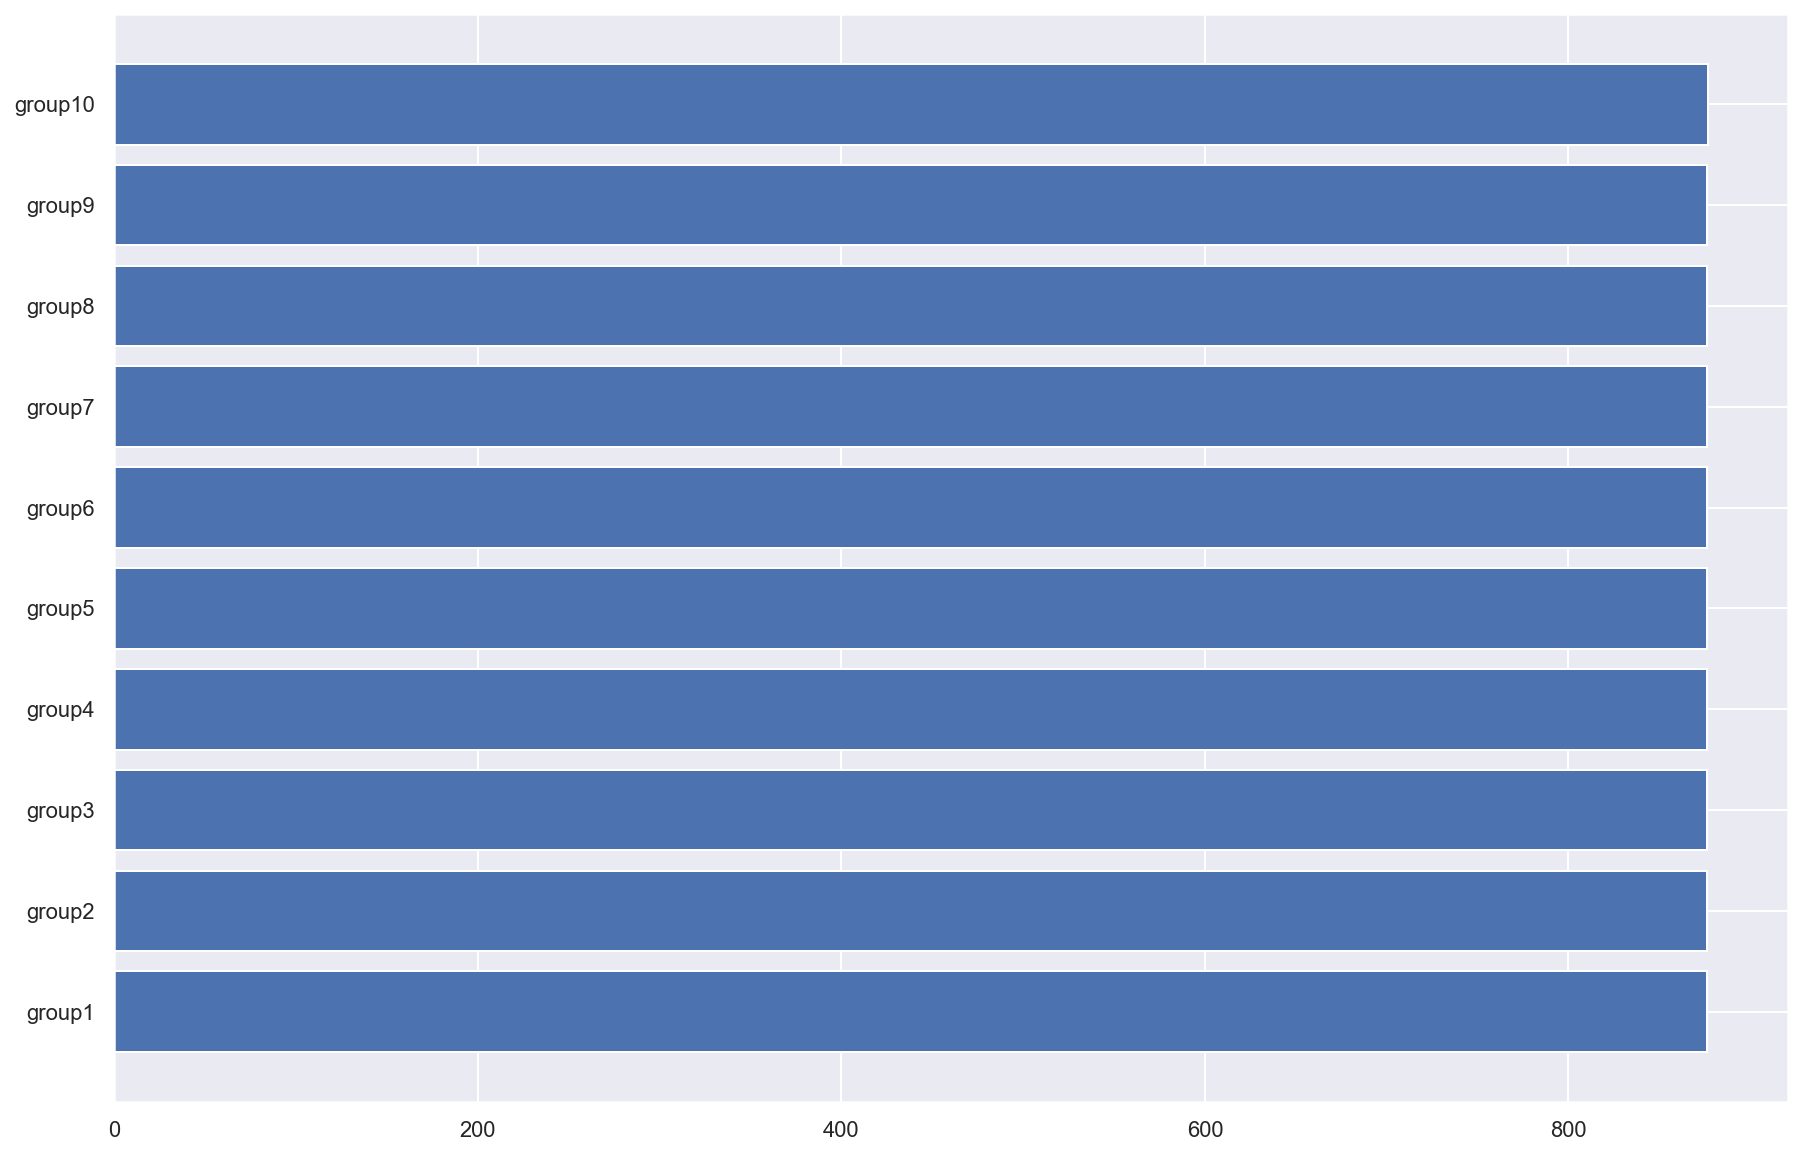

In [161]:
percentiles = discretize(data['L_T7'])
# fig = plt.plot(figsize=(7,3))
bars= ('group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7', 'group8', 'group9', 'group10')
plt.barh(np.arange(10), np.bincount(percentiles))
plt.yticks(np.arange(10), bars)

In [102]:
def fill_labels(w_size, data):
    label = []
    for j in range(len(data)):
        if(len(data) - j > w_size-1):
            if np.sum(data[j:j+w_size]):
                label.append(1)
            else:
                label.append(0)
    return label

def ngrams(words, n):
    gram_list = []
    d = collections.deque(maxlen=n)
    d.extend(words[:n])
    words = words[n:]
    for window, word in zip(itertools.cycle((d,)), words):
        gram_list.append(','.join(window))
        d.append(word)
    return gram_list

def generate_ngram_map(data, ngram):
    ngram_array = []
    ngram_map = {}
    ngram_array = ngrams([str(f) for f in data], ngram)
    ngram_map = dict.fromkeys(ngram_array, 0)
    return ngram_map

def fill_table(w_size, ngram, data, ngram_map):
    table = []
#     Reset the counts
    ngram_map = ngram_map.fromkeys(ngram_map, 0)
    for j in range(len(data)):
        if(len(data) - j > w_size-1):
            table.append(get_freq(ngram, data[j:j+w_size], ngram_map))
    return table

In [94]:
def detect_anomaly(test_df, train_df, y_train):
    labels = []
    sim_matrix = cosine_similarity(test_df, Y=train_df, dense_output=True)
    np.fill_diagonal(sim_matrix, -1)
    for i in range(len(test_df)):
        sim_row = sim_matrix[i]
        sim_idx = np.argmax(sim_row)
        if(y_train[sim_idx] == 1):
            labels.append(1)
        else:
            labels.append(0)
    return labels

def ngram_anomaly(train_df, test_df, w_size = 10, ngram = 3):
    att_labels = train_df['ATT_FLAG']
    train_df = train_df.drop(['ATT_FLAG'], axis =1)
    test_df = test_df.drop(['DATETIME'], axis =1)
    cosine_preds = pd.DataFrame(np.arange(len(test_df)-(w_size-1)), columns=['index'])
    for column in train_df:
        train_signal = train_df[column]
        percentiles = discretize(train_signal)

# Generate ngram map from the discretized data and len(ngram) in training set
        ngram_map = generate_ngram_map(data = percentiles, ngram = ngram)
# Generate table with window_index as rows and ngram freq as columns from training set
        ngram_table = fill_table(w_size, ngram, data = percentiles, ngram_map = ngram_map)
        ngram_df = pd.DataFrame(data = ngram_table)
        y_train = fill_labels(w_size, att_labels)
        print(len(y_train), ngram_df.shape)
        
# Generate table with window_index as rows and ngram freq as columns from test set
        test_signal = test_df[column]
        percentiles = discretize(test_signal)

        # Use the same n_gram map for testing
        ngram_table_test = fill_table(w_size, ngram, data = percentiles, ngram_map= ngram_map)
        ngram_df_test = pd.DataFrame(data=ngram_table_test)
        print(len(y_train), ngram_df_test.shape)
        y_preds = pd.DataFrame(detect_anomaly(ngram_df_test, ngram_df, y_train))
        cosine_preds[column] = pd.DataFrame(data= y_preds)

#     return pd.DataFrame(cosine_preds, columns=test_df.columns)
    return pd.DataFrame(cosine_preds)

In [104]:
cosine_preds = ngram_anomaly(dataA, 
              test_df.drop(['att_preds'], axis=1))

4168 (4168, 119)
4168 (2080, 119)
4168 (4168, 143)
4168 (2080, 143)
4168 (4168, 109)
4168 (2080, 109)
4168 (4168, 502)
4168 (2080, 502)
4168 (4168, 200)
4168 (2080, 200)
4168 (4168, 145)
4168 (2080, 145)
4168 (4168, 454)
4168 (2080, 454)
4168 (4168, 267)
4168 (2080, 267)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 235)
4168 (2080, 235)
4168 (4168, 6)
4168 (2080, 6)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 103)
4168 (2080, 103)
4168 (4168, 6)
4168 (2080, 6)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 443)
4168 (2080, 443)
4168 (4168, 8)
4168 (2080, 8)
4168 (4168, 187)
4168 (2080, 187)
4168 (4168, 6)
4168 (2080, 6)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 513)
4168 (2080, 513)
4168 (4168, 8)
4168 (2080, 8)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 1)
4168 (2080, 1)
4168 (4168, 326)
4168 (2080, 326)
4168 (4168, 6)
4168 (2080, 6)
4168 (4168, 19

In [162]:
cosine_preds.drop(['index'], axis=1)

def unpack_windows(cosine_preds, w_size, threshold):
    df = pd.DataFrame(np.arange(len(test_df)), columns=['index'])
    window_map = dict.fromkeys(np.arange(len(test_df)), 0)
    for column in cosine_preds:
        y_preds = cosine_preds[column]
        for i in range(len(y_preds)):
            for j in range(i, i+w_size-1):
                freq = window_map.get(j)
                if y_preds[i]:
                    window_map[j] = freq + 1
        df[column] = pd.DataFrame(list(window_map.values()))
        df[column] = df[column].apply(lambda x: 1 if (x) > threshold else 0)
        
    return df.drop(['index'], axis=1)

In [163]:
w_size = 10
predictions_df = unpack_windows(cosine_preds, w_size, threshold = w_size)

att_preds = []
for i in range(len(predictions_df)):
    att_preds.append(1 if np.sum(predictions_df.iloc[i].values) > 1 else 0)
    
test_df['att_preds'] = pd.DataFrame(att_preds)

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Anomaly')]

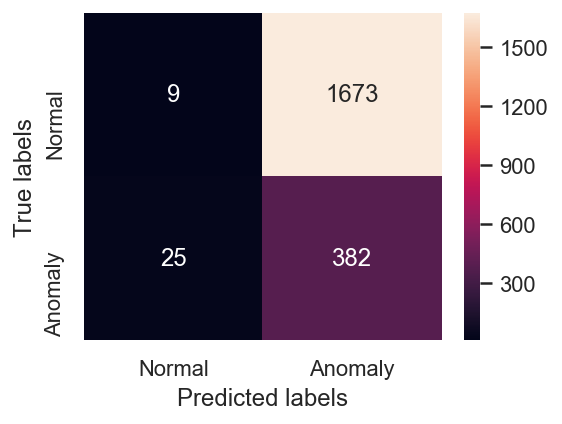

In [164]:
cm1 = confusion_matrix(y_test, test_df['att_preds'].values)
akws = {"ha": 'center',"va": 'center'}
fig = plt.figure( figsize=(4,3))
fig = plt.plot(figsize=(7,3))
ax = sns.heatmap(cm1, annot=True, fmt="d", annot_kws=akws)

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
# ax.set_title('Confusion Matrix-UnSmoted NB')
ax.xaxis.set_ticklabels(['Normal', 'Anomaly']); ax.yaxis.set_ticklabels(['Normal', 'Anomaly'])

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.

In [ ]:





### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

Dataset here : https://www.batadal.net/data.html You will need Training Dataset 1, Training Dataset 1 and Test Dataset.